# Topyfic on mouse C2C12 single cell data from ENCODE
### *Narges Rezaie*
#### Vignette built on Jan 3, 2023 with Topyfic version 0.1.0.

The aim of this tutorials is to introduce the basic concepts behind an analysis of single-cell RNA-seq data using a Latent Dirichlet allocation (LDA), and to show how to use Topyfic to implement it and analyse the results. We introduce the basic concepts and Topyfic interface through a simple example using C2C12 data from [this paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02505-w) and get the data from ENCODE data using [this card](https://www.encodeproject.org/carts/78195d59-2113-4199-8566-fa81750693f8/). After following [this protocol](https://github.com/erebboah/enc4_mouse), I normalized data using [this paper](https://www.biorxiv.org/content/10.1101/2022.05.06.490859v1.full).

## Input data

Training steps (creating train object) might take a few hours to run, as reference we mention the running time for this dataset and settings in our system. Your actual running time will depend on your computer and dataset. In this tutorial, we will run Topyfic in 22,234 C2C12 cells from [this paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02505-w). We pooled out the count matrix using [ENCODE portal](https://www.encodeproject.org/) and annoted them. 

In this toturial, we hypothesize that we can characterize tissue by only looking at the subset of regulatory genes including TFs, microRNA host genes, and chromatin regulatory genes which together account for 12%(2,701 genes) of the protein coding genes.

Here, we showed the distrbution of gene biotype, we choosed for this tutorial.

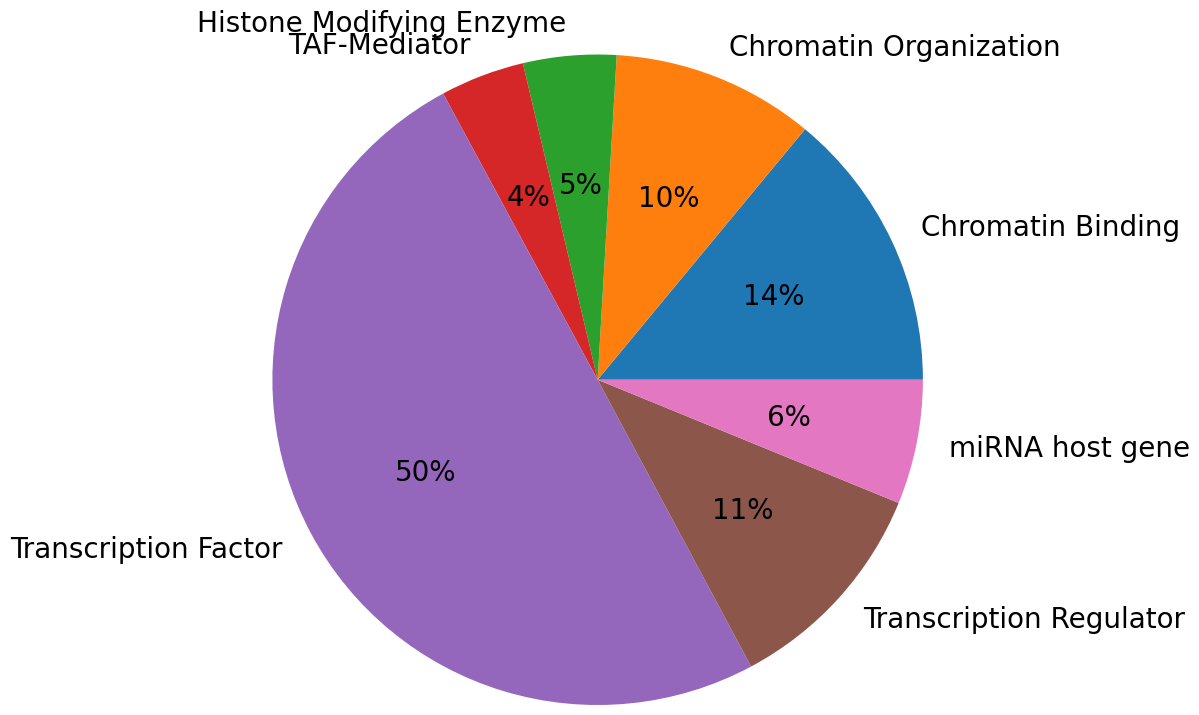

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

genes = pd.read_csv("../gene_display_table.csv", index_col=0)
genes['count'] = 1
res = genes.groupby(by=["cat_biotype"]).sum()
res['count'] = res['count'] / res.sum().sum() * 100

mycolors = ["lightgray", "lightblue", "pink", "bisque"]
textprops = {"fontsize":20}

plt.pie(res['count'].values, 
       labels = res.index, 
       #colors = mycolors,
       autopct='%1.0f%%',
       radius = 2.2,
       textprops =textprops)
plt.show()

We begin our analysis by loading the libraries.

In [1]:
import Topyfic
import pandas as pd
import scanpy as sc
import numpy as np
import random

Topyfic can be initialized from precomputed matrix with cells as row, genes as columns and reads counts as value embeded in AnnData format along with cell information stored in obs and gene information in var. you can also use the output of scanpy/seurat object which saved as h5ad file.

In [2]:
tissue = "C2C12"
data = sc.read_h5ad("C2C12_TFs_mirhgs_chromreg.h5ad")
data

AnnData object with n_obs × n_vars = 22234 × 2701
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'file_accession', 'library_accession', 'experiment_accession', 'nCount_SCT', 'nFeature_SCT', 'technology', 'species', 'tissue', 'sex', 'timepoint', 'rep', 'sample', 'depth1', 'depth2', 'experiment', 'experiment_batch', 'integration_batch', 'run_number', 'doublet_scores', 'doublets', 'lower_nCount_RNA', 'upper_nCount_RNA', 'lower_nFeature_RNA', 'upper_doublet_scores', 'upper_percent.mt', 'percent.mt', 'percent.ribo', 'S.Score', 'G2M.Score', 'Phase', 'seurat_clusters', 'subtypes', 'gen_celltype', 'c2c12_cluster', 'celltypes', 'monocle3_pseudotime'

## make Train model
The next step is making our train model and learning LDA model serveral times(default is 100 time).

The main parameters for making Train object are:

* number of topics(k): number of topics to learn one LDA model using sklearn package (default: 50)

* number of tuns(n_runs): number of runs to define rLDA model (default: 100)

* list of seed for train LDA models (random_state_range): list of random state, we used to run LDA models (default: range(n_runs))

**Note**: To fit a LDA, we must specify K, the number of topics. Here, we have chosen K=14 topics. In most settings, a good choice of K will not be known in advance, so you will you want to explore the results from topic models at different settings of K.

In [3]:
train = Topyfic.Train(name="C2C12",
                      k=14,
                      n_runs=100)

## run LDA models
Now we have our Train object, we need to build our single LDA models.

The main parameters for runing LDA models are:

* data: expression data embedded in anndata format
* n_jobs: The number of jobs to use in the E-step. See [Glossary](https://scikit-learn.org/stable/glossary.html#term-n_jobs) for more details.
* n_thread: number of threads you used to learn LDA models.

**Note**: base on your data and your system this step may take a while.

In [ ]:
train.run_LDA_models(data, n_jobs=5, n_thread=5)

## Saving and loading your Train object

you can save or load your Train object with `save_train()` or `read_train()` function.

In [ ]:
train.save_train()

In [4]:
train = Topyfic.read_train("train_C2C12.p")

Reading Train done!


## Make TopModel object

Here, we used leiden clustring to found our reproducible topics and make TopModel object.

The main parameters for making TopModel object are:

* trains: list of train objects
* data: gene-count data with cells and genes information
* n_top_genes: Number of highly-variable genes to keep (default: 50)
* resolution: A parameter value controlling the coarseness of the clustering. Higher values lead to more clusters. (default: 1)
* min_cell_participation: minimum cell participation across for each topics to keep them, when is None, it will keep topics with cell participation more than number of cell / 10000.


         Falling back to preprocessing with `sc.pp.pca` and default params.


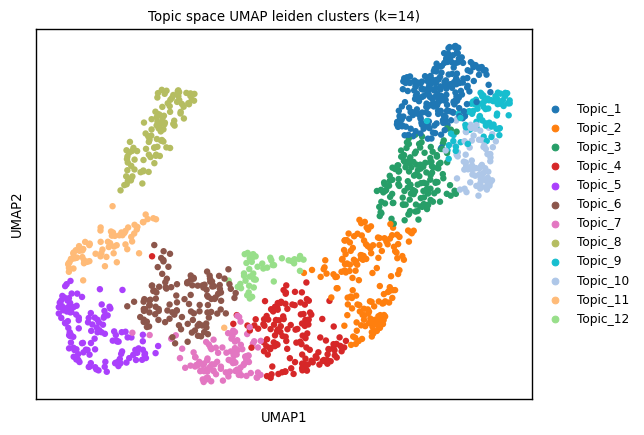

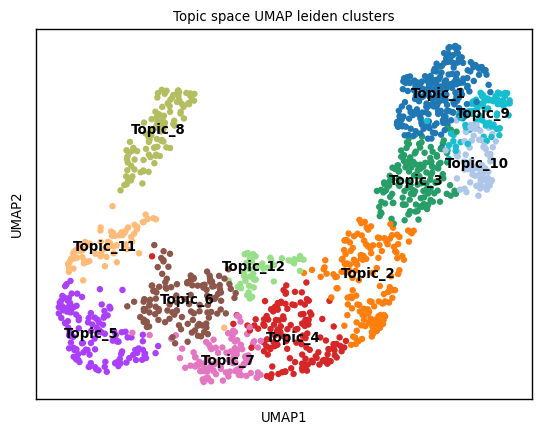

12 topics out of 12 topics have participation more than 2.2234


In [5]:
top_model, clustering = Topyfic.calculate_leiden_clustering(trains=[train], data=data)

## Saving and loading your TopModel object

you can save or load your TopModel object with `save_topModel()` or `read_topModel()` function.

In [ ]:
top_model.save_topModel()

In [6]:
top_model = Topyfic.read_topModel("topModel_C2C12.p")

Reading TopModel done!


## Making analysis object

Now you have your topModel object which include our rLDA model. For doing downstream analysis, you have to make analysis object which include calculating cell participation for each topics.

you can also define color for each topic or the package will pick randomly.

In [ ]:
analysis_top_model = Topyfic.Analysis(Top_model=top_model)

## Cell participation: each cell is represented as a unique mixture of topics
A key feature of the topic model is that each cell i is represented as a unique mixture of the topics. Therefore, each cell can be summarized from the N mixture proportions.

In [ ]:
analysis_top_model.calculate_cell_participation(data=data)

## Saving and loading your analysis object

you can save or load your TopModel object with `save_analysis()` or `read_analysis()` function.

In [ ]:
analysis_top_model.save_analysis()

In [7]:
analysis_top_model = Topyfic.read_analysis("analysis_C2C12.p")

Reading TopModel done!


## Interpreting topics using available cell annotations

In some cases, you may have additional information about the cells, such as the timepoint, sex, tissue or cell types the cells were sampled from. In our C2C12 data, we have different cell types/ sub types and time points along with thier seurat object (For more information look at [this paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02505-w).

There is several ways to visualize the relationship between the cell labels and the mixture proportions.

### Create a Topic_Trait relationship heatmap
which shows the pearson correlation coefficient (color) and p-value (number in paranteces) for testing non-correlation between each topics and data traits.

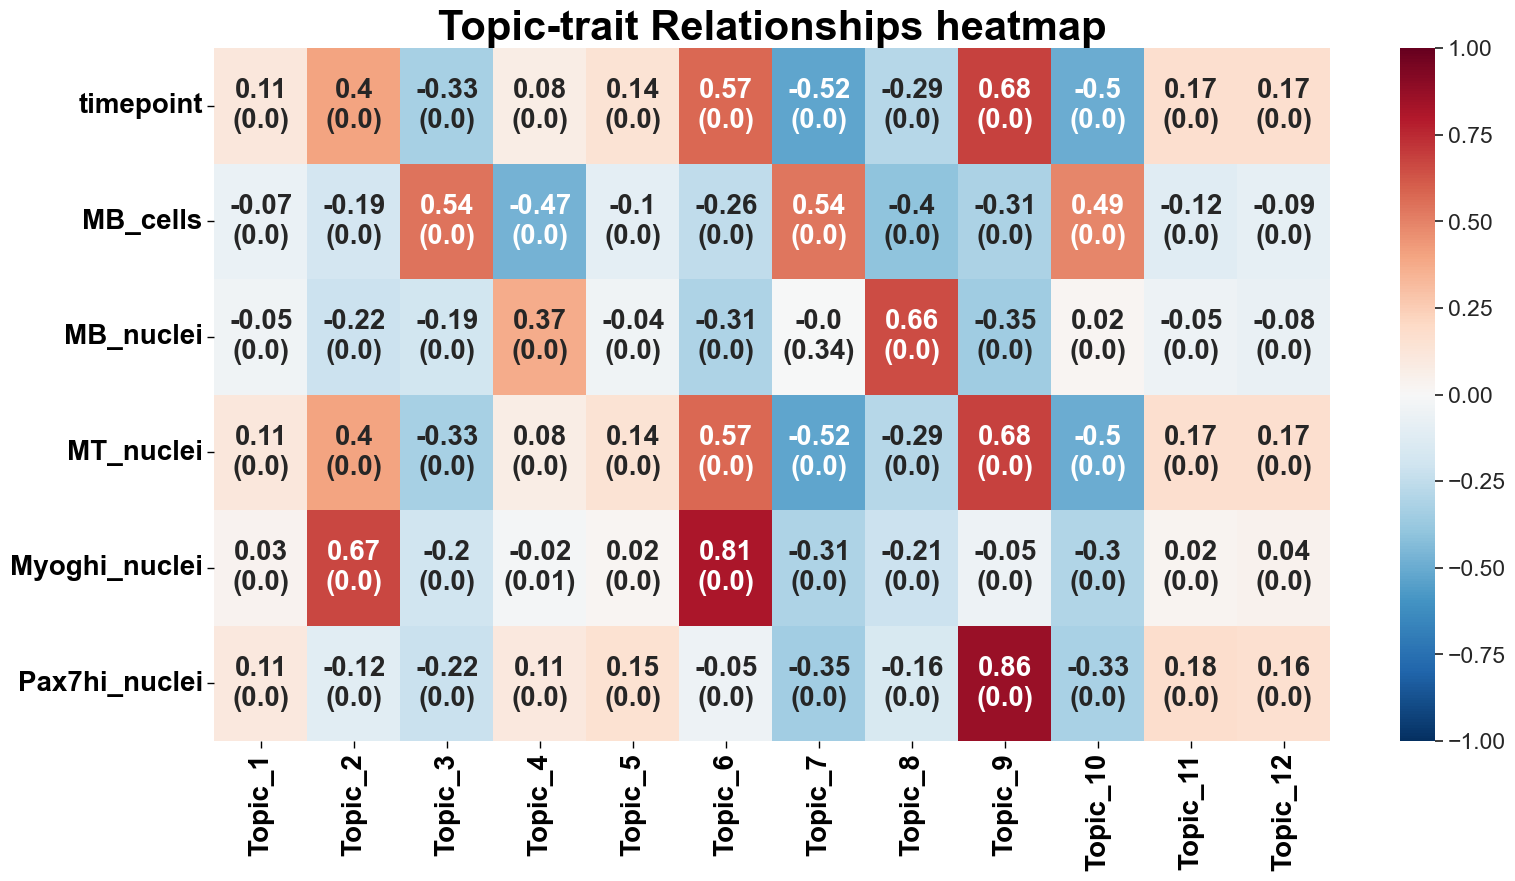

In [8]:
metadata = ['timepoint','celltypes','subtypes']
analysis_top_model.TopicTraitRelationshipHeatmap(metaData=metadata,
                                                 save=True,
                                                 show=True,
                                                 file_name='figures/topic-traitRelationships')

### Average cell participation
you can plot the avarage of cell participation for each topics.

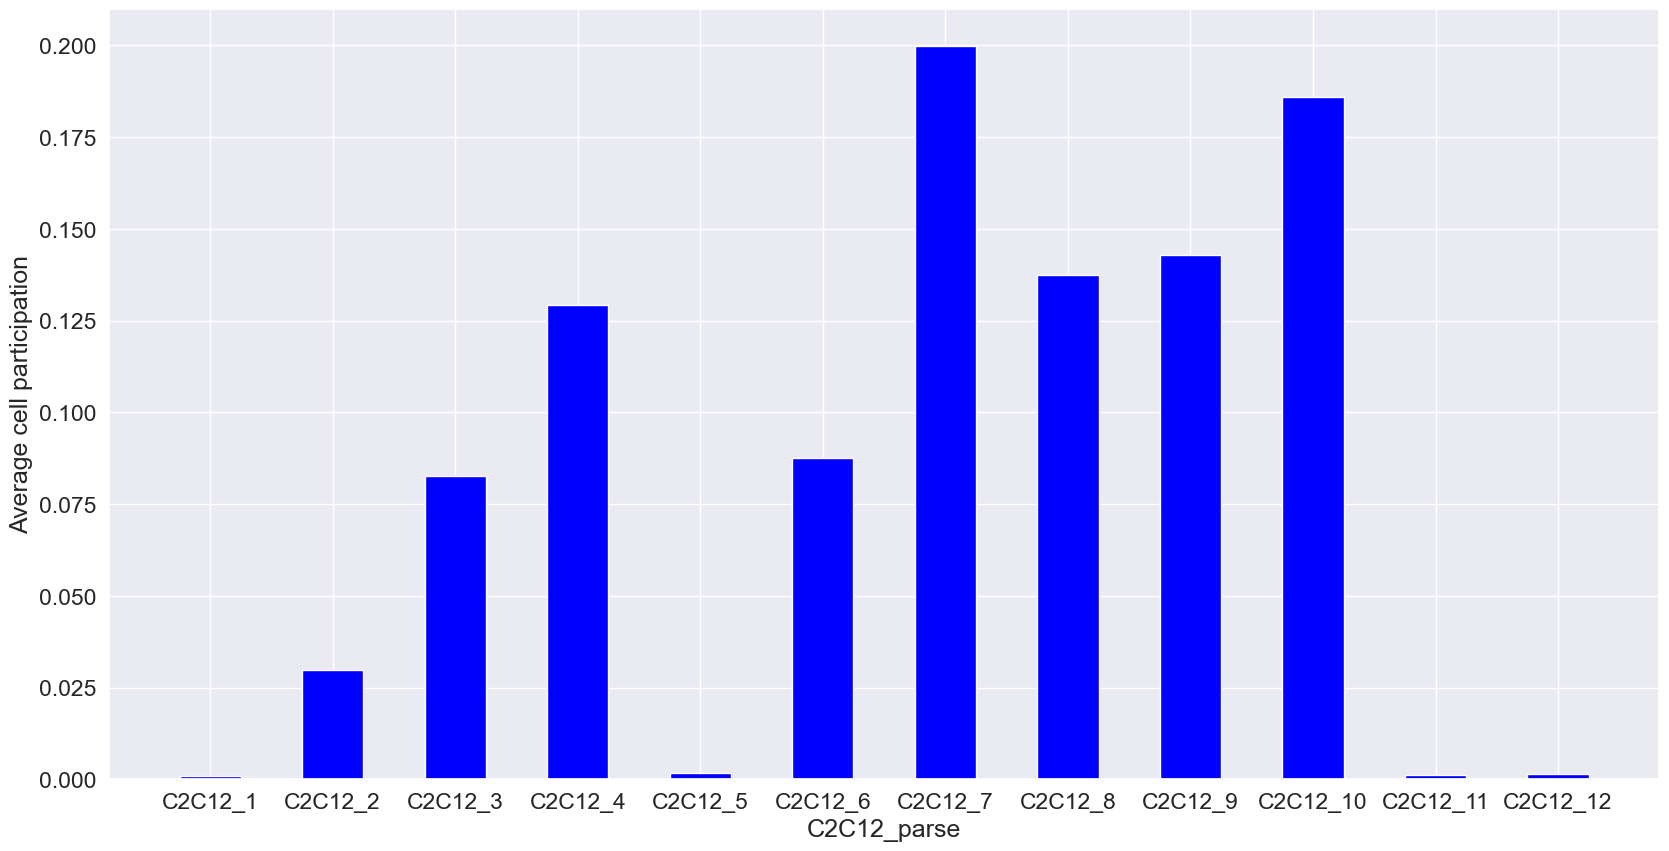

In [9]:
label = dict()
for i in range(analysis_top_model.top_model.N):
    key = f"Topic_{i+1}"
    value = f"C2C12_{i+1}"
    label[key] = value

analysis_top_model.average_cell_participation(label=label,
                                              figsize=(20,10),
                                              file_name="figures/average_cell_participation")

### Creat pie chart

The pie charts show the contrubution of each topics to each data traits.

For example here, we plot pie charts for each subtypes of data we have.

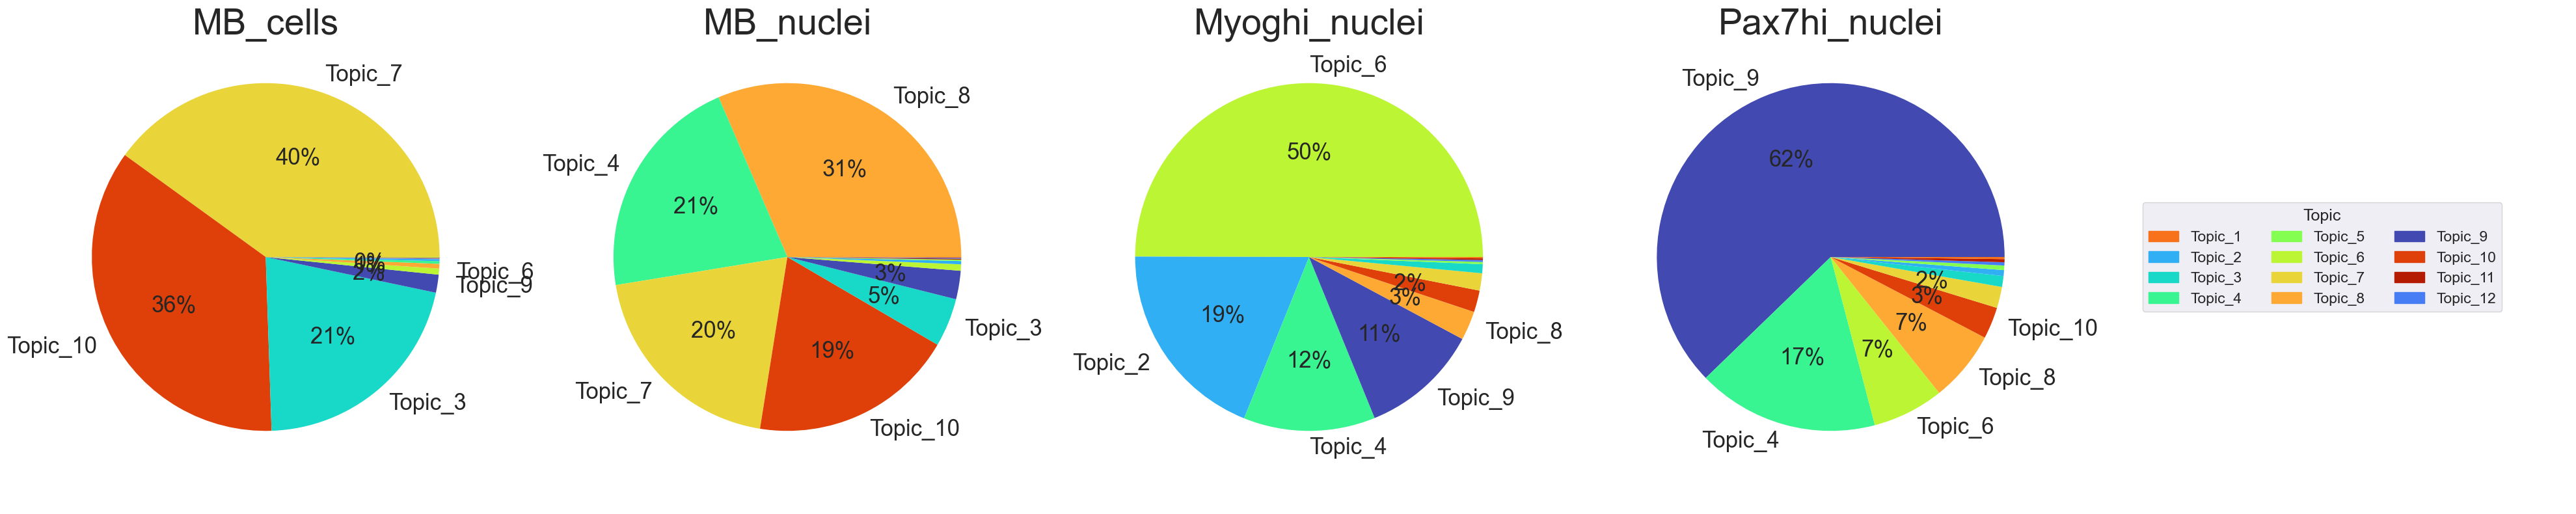

In [10]:
subtypes = ['MB_cells', 'MB_nuclei', 'Myoghi_nuclei', 'Pax7hi_nuclei']
file_name = f"figures/pieChart/dist_topics_subtypes_RNA"
analysis_top_model.pie_structure_Chart(level='subtypes',
                                       category=subtypes,
                                       save=True,
                                       show=True,
                                       file_name=file_name)

###  Create sctructure plots

The Structure plot is a simply stacked bar chart, in which each topic is represented as a bar of a different color. 
Being proportions, the mixture proportions for each cell must sum to 1, so the total height of the bars is the same for all cells, which makes it easier to compare across cells. 
Patterns begin to emerge when the cells are arranged so that cells with similar mixture proportions are positioned close to each other using hierarchy clustering (**hierarchy**). There is also other opthion to sort your cells like **sum** (sort cells by sum of top n topics) or just sort by **metaData**.

you should also pass color palette for data trait you want to add in your structure plot.
In our data sets we want to add time point of the cell and their clusters.

In [11]:
my_palette_timepoint = {'0hr': 'yellow',
                        '72hr': 'orange'}
my_palette_c2c12_cluster = {}
for name in np.unique(data.obs['c2c12_cluster']):
    my_palette_c2c12_cluster[name] = "#"+''.join([random.choice('ABCDEF0123456789') for i in 
range(6)])

my_palette = {'timepoint' : my_palette_timepoint,
              'c2c12_cluster': my_palette_c2c12_cluster}

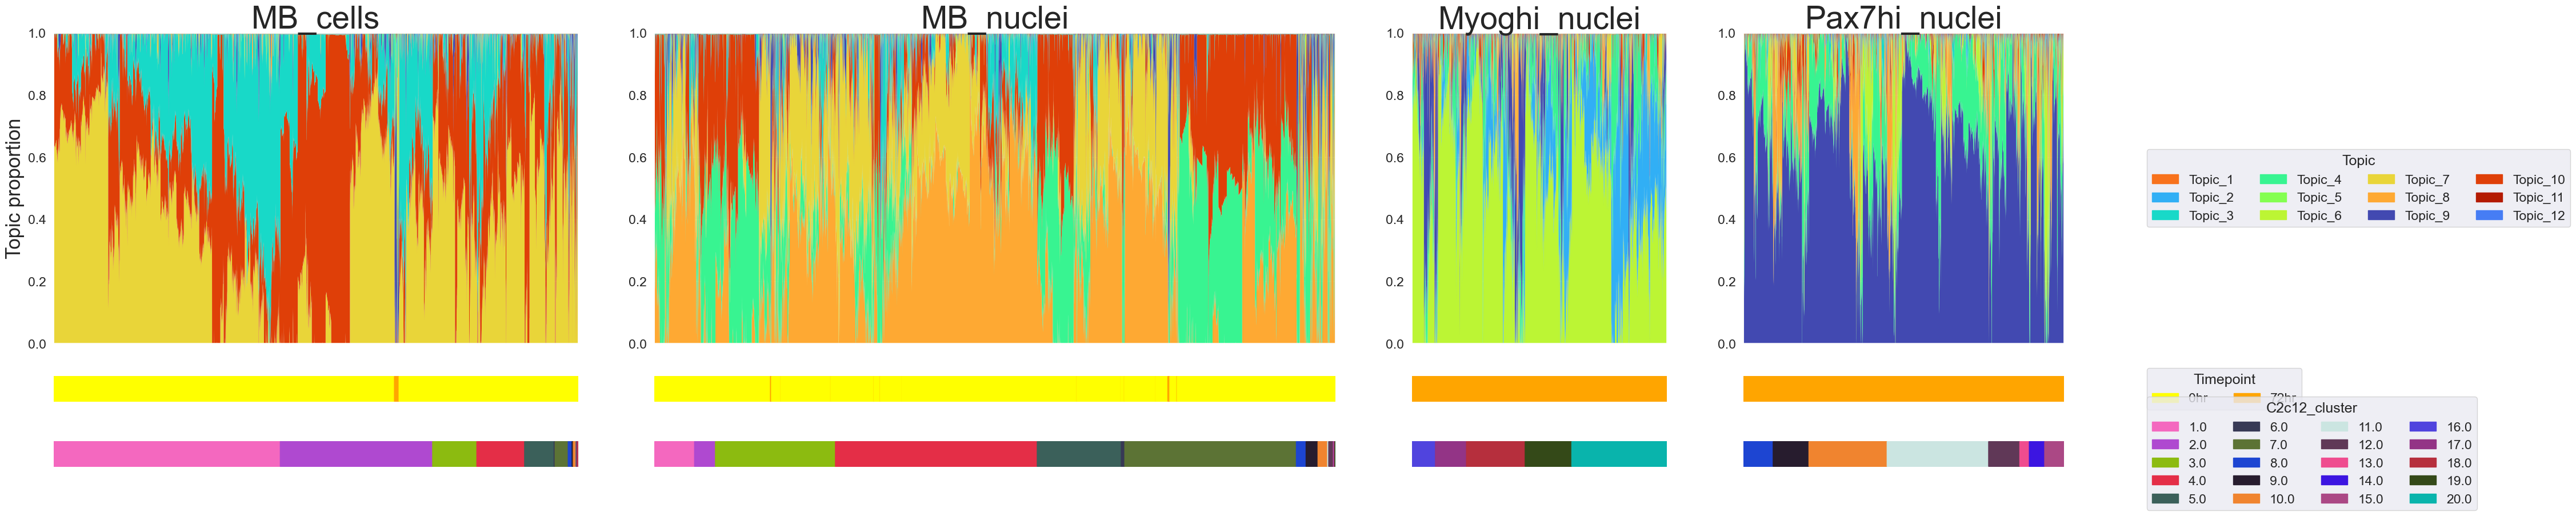

In [12]:
subtypes = ['MB_cells', 'MB_nuclei', 'Myoghi_nuclei', 'Pax7hi_nuclei']
file_name = f"figures/structurePlot/dist_topics_subtypes_RNA_cluster_hierarchical"
analysis_top_model.structure_plot(level='subtypes',
                                  category=subtypes, 
                                  metaData=["timepoint", "c2c12_cluster"],
                                  metaData_palette=my_palette,
                                  order_cells=["c2c12_cluster", 'hierarchy'],
                                  save=True,
                                  show=True,
                                  file_name=file_name)

### gene topic weights

one of the way to analyse the topics is looking at the weights of each genes in each topics. you can access to this information using `get_gene_weights()` function.

In [13]:
gene_weights = top_model.get_gene_weights()
gene_weights

,C2C12_parse_Topic_1,C2C12_parse_Topic_2,C2C12_parse_Topic_3,C2C12_parse_Topic_4,C2C12_parse_Topic_5,C2C12_parse_Topic_6,C2C12_parse_Topic_7,C2C12_parse_Topic_8,C2C12_parse_Topic_9,C2C12_parse_Topic_10,C2C12_parse_Topic_11,C2C12_parse_Topic_12
Sox17,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
St18,13.461459,0.083333,0.083333,0.083333,18.282968,0.083333,0.083333,0.083333,0.083333,0.083333,11.803827,26.366678
Mybl1,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,513.110667,0.083333,0.083333,0.083333,0.083333,0.083333
Tcf24,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
Cops5,0.083333,0.083333,219.073974,0.083333,0.083333,123.658655,713.104617,264.999592,323.695316,0.083333,0.083333,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...
Kdm5d,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
Uty,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
Zfy2,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
Sry,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333


### gene rank with their weights in each topic

if you want to look at the genes in each topics sorted by their weights you can use`get_ranked_gene_weight()` function.

In [14]:
gene_rank_weights = top_model.get_ranked_gene_weight()
gene_rank_weights

,C2C12_parse_Topic_1,C2C12_parse_Topic_2,C2C12_parse_Topic_3,C2C12_parse_Topic_4,C2C12_parse_Topic_5,C2C12_parse_Topic_6,C2C12_parse_Topic_7,C2C12_parse_Topic_8,C2C12_parse_Topic_9,C2C12_parse_Topic_10,C2C12_parse_Topic_11,C2C12_parse_Topic_12
0,Esr1;350.0698863758329,Gm28653;1687.0409010196722,Actb;5713.986639499303,Runx1;10388.598510587732,Ryr1;554.6370723881346,Zbtb20;5429.865819226324,Actb;6277.7626214144875,Runx1;7952.870682101743,Zbtb20;11357.341591663155,Actb;10880.307124582401,Zfp973;895.3357440951071,Arpp21;395.20041564986985
1,Npas3;251.11748452753852,Xist;1567.9017829192155,Ptma;4772.346382825384,Pbx1;7375.270051962422,Gm49317;534.9119255793378,Xist;4186.442149341854,Ncl;5734.998690133762,Pbx1;5824.399459389631,Xist;7004.894835526622,Ncl;10152.115673237055,Igf2;622.9062250970936,Esr1;386.83048248418595
2,Ryr1;215.91940830310298,Mef2a;1552.5032163527364,Lmna;4410.535361223518,Maml3;6618.5009106764,Arpp21;455.4265243478084,Zeb1;3274.382463790307,Ptma;5727.235573666004,Hmga2;5314.944134825369,Airn;6342.69071302367,Ptma;9787.524243442029,Gm49394;608.9001072786323,Gm14410;321.12772196127537
3,Gm49317;211.43913386122858,Runx1;1499.3433214978925,Ncl;3522.6160882087365,Zbtb20;6431.2716303036295,Bcl6;433.2665260084877,Runx1;3264.04262378599,Xist;3949.3747732842494,Maml3;5224.675122130341,Tcf4;6065.363867190054,Xist;7984.229761008174,Bcl6;508.3932593003831,Gm20422;283.453340865949
4,Camta1;181.03501086549932,Zbtb20;1493.1249715724416,Eno1;3349.542065839261,Atxn1;6254.389041957804,Airn;373.2598867699143,Airn;3176.49028829616,Lmna;3854.285509446104,Zbtb20;5139.683227279863,Runx1;5819.628729599287,Top2a;7425.675601113239,Atf7;481.8839516486032,Igf2;281.42924264924415
...,...,...,...,...,...,...,...,...,...,...,...,...
2696,Zscan4f;0.08333333333333333,Eid2;0.08333333333333333,Zfp626;0.08333333333333333,Npas1;0.08333333333333333,Zfp788;0.08333333333333333,Eid2b;0.08333333333333333,Etv2;0.08333333333333333,Fbl;0.08333333333333333,Dyrk1b;0.08333333333333333,Zfp551;0.08333333333333333,Arntl2;0.08333333333333333,Zfp628;0.08333333333333333
2697,Zscan4-ps2;0.08333333333333333,Dyrk1b;0.08333333333333333,Zfp60;0.08333333333333333,Hif3a;0.08333333333333333,Gm6871;0.08333333333333333,Eid2;0.08333333333333333,Zbtb32;0.08333333333333333,Dyrk1b;0.08333333333333333,Fbl;0.08333333333333333,Zfp606;0.08333333333333333,Resf1;0.08333333333333333,Zfp865;0.08333333333333333
2698,Zscan4-ps3;0.08333333333333333,Fbl;0.08333333333333333,Zfp607b;0.08333333333333333,Mypop;0.08333333333333333,AI987944;0.08333333333333333,Dyrk1b;0.08333333333333333,Ovol3;0.08333333333333333,Eid2;0.08333333333333333,Zfp850;0.08333333333333333,Zscan18;0.08333333333333333,Tfpt;0.08333333333333333,Zfp784;0.08333333333333333
2699,Zfp551;0.08333333333333333,Zfp850;0.08333333333333333,Map3k10;0.08333333333333333,Irf2bp1;0.08333333333333333,Uri1;0.08333333333333333,Fbl;0.08333333333333333,Polr2i;0.08333333333333333,Eid2b;0.08333333333333333,Zfp780b;0.08333333333333333,Zfp329;0.08333333333333333,Kmt5c;0.08333333333333333,Zfp580;0.08333333333333333


### plot gene weights

plot gene weights of your list of genes with their ranks

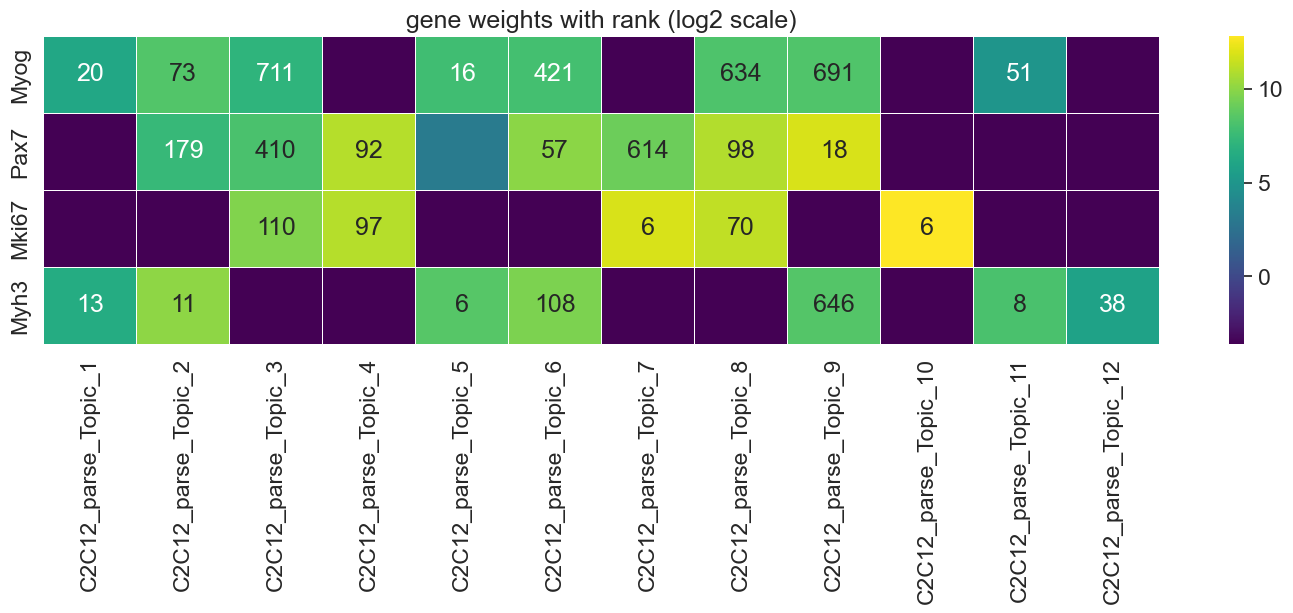

In [15]:
top_model.gene_weight_rank_heatmap(genes=["Myog",
                                          "Pax7",
                                          "Mki67",
                                          "Myh3",],
                                   scale="log2",
                                   file_name="figures/gene_weight_rank_heatmap")

### Create Line plot
plot the avarage cell participation for each topics using two information of data traits (one as a x axis and the other one for different lines.

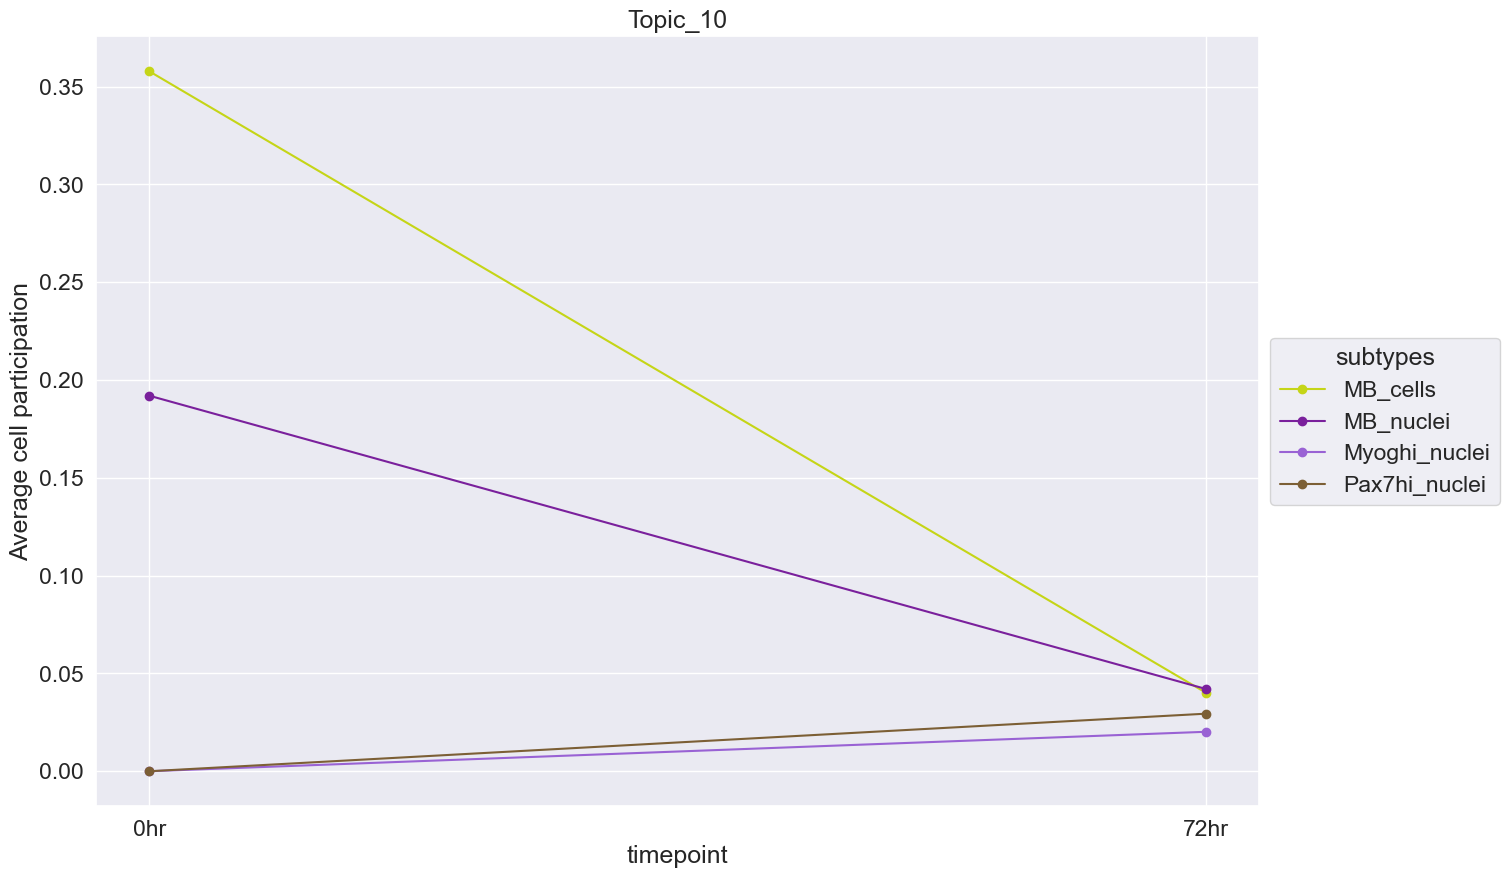

In [16]:
my_palette_subtypes = {}
for name in np.unique(data.obs['subtypes']):
    my_palette_subtypes[name] = "#"+''.join([random.choice('ABCDEF0123456789') for i in 
range(6)])

analysis_top_model.average_cell_participation_line_plot(topic=f"Topic_10",
                                                        color='subtypes',
                                                        color_pallet=my_palette_subtypes,
                                                        category="timepoint",
                                                        figsize=(15,10),
                                                        save=True,
                                                        show=True,
                                                        file_name=f"figures/linePlot/subtypes_timepoint_Topic_10")

## Gene Set Enrichment Analysis (GSEA) analysis

perform GSEA analysis on each topic, to help us understand topics better.

In [4]:
for topic in top_model.topics.keys():
    print(f"Calculating GSEA for topic {topic}")
    top_model.topics[topic].GSEA(file_name=f"figures/GSEA/topic_{topic}",
                                 verbose=True)

2023-02-16 11:22:05,973 Parsing data files for GSEA.............................
2023-02-16 11:22:05,974 Enrichr library gene sets already downloaded in: /Users/nargesrezaie/.cache/gseapy, use local file
2023-02-16 11:22:06,063 6016 gene_sets have been filtered out when max_size=500 and min_size=15
2023-02-16 11:22:06,064 0020 gene_sets used for further statistical testing.....
2023-02-16 11:22:06,064 Start to run GSEA...Might take a while..................
2023-02-16 11:22:06,115 Congratulations. GSEApy runs successfully................



Calculating GSEA for topic Topic_1


2023-02-16 11:22:09,093 Parsing data files for GSEA.............................
2023-02-16 11:22:09,093 Enrichr library gene sets already downloaded in: /Users/nargesrezaie/.cache/gseapy, use local file
2023-02-16 11:22:09,158 5937 gene_sets have been filtered out when max_size=500 and min_size=15
2023-02-16 11:22:09,159 0099 gene_sets used for further statistical testing.....
2023-02-16 11:22:09,159 Start to run GSEA...Might take a while..................


Calculating GSEA for topic Topic_2


2023-02-16 11:22:09,400 Congratulations. GSEApy runs successfully................

2023-02-16 11:22:11,654 Parsing data files for GSEA.............................
2023-02-16 11:22:11,655 Enrichr library gene sets already downloaded in: /Users/nargesrezaie/.cache/gseapy, use local file
2023-02-16 11:22:11,719 5885 gene_sets have been filtered out when max_size=500 and min_size=15
2023-02-16 11:22:11,720 0151 gene_sets used for further statistical testing.....
2023-02-16 11:22:11,720 Start to run GSEA...Might take a while..................


Calculating GSEA for topic Topic_3


2023-02-16 11:22:12,059 Congratulations. GSEApy runs successfully................

2023-02-16 11:22:21,253 Parsing data files for GSEA.............................
2023-02-16 11:22:21,254 Enrichr library gene sets already downloaded in: /Users/nargesrezaie/.cache/gseapy, use local file
2023-02-16 11:22:21,329 5987 gene_sets have been filtered out when max_size=500 and min_size=15
2023-02-16 11:22:21,330 0049 gene_sets used for further statistical testing.....
2023-02-16 11:22:21,330 Start to run GSEA...Might take a while..................


Calculating GSEA for topic Topic_4


2023-02-16 11:22:21,478 Congratulations. GSEApy runs successfully................

2023-02-16 11:22:21,980 Parsing data files for GSEA.............................
2023-02-16 11:22:21,980 Enrichr library gene sets already downloaded in: /Users/nargesrezaie/.cache/gseapy, use local file
2023-02-16 11:22:22,047 5940 gene_sets have been filtered out when max_size=500 and min_size=15
2023-02-16 11:22:22,048 0096 gene_sets used for further statistical testing.....
2023-02-16 11:22:22,049 Start to run GSEA...Might take a while..................


Calculating GSEA for topic Topic_5


2023-02-16 11:22:22,470 Congratulations. GSEApy runs successfully................

2023-02-16 11:22:23,545 Parsing data files for GSEA.............................
2023-02-16 11:22:23,546 Enrichr library gene sets already downloaded in: /Users/nargesrezaie/.cache/gseapy, use local file
2023-02-16 11:22:23,605 5916 gene_sets have been filtered out when max_size=500 and min_size=15
2023-02-16 11:22:23,606 0120 gene_sets used for further statistical testing.....
2023-02-16 11:22:23,606 Start to run GSEA...Might take a while..................


Calculating GSEA for topic Topic_6


2023-02-16 11:22:23,857 Congratulations. GSEApy runs successfully................

2023-02-16 11:22:26,213 Parsing data files for GSEA.............................
2023-02-16 11:22:26,213 Enrichr library gene sets already downloaded in: /Users/nargesrezaie/.cache/gseapy, use local file
2023-02-16 11:22:26,276 5836 gene_sets have been filtered out when max_size=500 and min_size=15
2023-02-16 11:22:26,277 0200 gene_sets used for further statistical testing.....
2023-02-16 11:22:26,277 Start to run GSEA...Might take a while..................


Calculating GSEA for topic Topic_7


2023-02-16 11:22:26,767 Congratulations. GSEApy runs successfully................

2023-02-16 11:22:39,717 Parsing data files for GSEA.............................
2023-02-16 11:22:39,717 Enrichr library gene sets already downloaded in: /Users/nargesrezaie/.cache/gseapy, use local file
2023-02-16 11:22:39,779 5932 gene_sets have been filtered out when max_size=500 and min_size=15
2023-02-16 11:22:39,780 0104 gene_sets used for further statistical testing.....
2023-02-16 11:22:39,781 Start to run GSEA...Might take a while..................


Calculating GSEA for topic Topic_8


2023-02-16 11:22:40,055 Congratulations. GSEApy runs successfully................

2023-02-16 11:22:44,981 Parsing data files for GSEA.............................
2023-02-16 11:22:44,981 Enrichr library gene sets already downloaded in: /Users/nargesrezaie/.cache/gseapy, use local file
2023-02-16 11:22:45,112 5913 gene_sets have been filtered out when max_size=500 and min_size=15
2023-02-16 11:22:45,113 0123 gene_sets used for further statistical testing.....
2023-02-16 11:22:45,113 Start to run GSEA...Might take a while..................


Calculating GSEA for topic Topic_9


2023-02-16 11:22:45,451 Congratulations. GSEApy runs successfully................

2023-02-16 11:22:50,629 Parsing data files for GSEA.............................
2023-02-16 11:22:50,629 Enrichr library gene sets already downloaded in: /Users/nargesrezaie/.cache/gseapy, use local file
2023-02-16 11:22:50,703 5992 gene_sets have been filtered out when max_size=500 and min_size=15
2023-02-16 11:22:50,704 0044 gene_sets used for further statistical testing.....
2023-02-16 11:22:50,705 Start to run GSEA...Might take a while..................


Calculating GSEA for topic Topic_10


2023-02-16 11:22:50,829 Congratulations. GSEApy runs successfully................

2023-02-16 11:22:54,768 Parsing data files for GSEA.............................
2023-02-16 11:22:54,768 Enrichr library gene sets already downloaded in: /Users/nargesrezaie/.cache/gseapy, use local file
2023-02-16 11:22:54,830 6023 gene_sets have been filtered out when max_size=500 and min_size=15
2023-02-16 11:22:54,831 0013 gene_sets used for further statistical testing.....
2023-02-16 11:22:54,831 Start to run GSEA...Might take a while..................
2023-02-16 11:22:54,860 Congratulations. GSEApy runs successfully................



Calculating GSEA for topic Topic_11


2023-02-16 11:22:55,183 Parsing data files for GSEA.............................
2023-02-16 11:22:55,184 Enrichr library gene sets already downloaded in: /Users/nargesrezaie/.cache/gseapy, use local file
2023-02-16 11:22:55,280 6024 gene_sets have been filtered out when max_size=500 and min_size=15
2023-02-16 11:22:55,281 0012 gene_sets used for further statistical testing.....
2023-02-16 11:22:55,282 Start to run GSEA...Might take a while..................
2023-02-16 11:22:55,321 Congratulations. GSEApy runs successfully................



Calculating GSEA for topic Topic_12


***if you need more infor about the inputs of each functions look at the API documentation [here](https://mortazavilab.github.io/Topyfic/html/api.html).***